# Konwolucyjne sieci neuronowe - CNN

https://www.youtube.com/watch?v=HGwBXDKFk9I&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1&index=14

## Teoria

1. **Czym jest filtr/kernel?** - macierz przykładana do wycinków obrazu (obliczamy jej konwolucję z kolejnymi fragmentami obrazu)

 - rozmiar filtra - zazwyczaj 3x3
 - liczba używanych filtrów (ile może ich być) - może być dużo, każdy na innym kanale; np. jeden szuka krawędzi poziomych, a drugi pionowych
 - wygląd input/output - np. przy obrazku 6x6: mamy wejście 6x6, wyjście 4x4

2. **Co się dzieje z obrazkami 3D? Jak zastosować filtry?**
Obrazek 6x6x3 -> filtr 3x3 staje się tensorem 3x3x3 i liczy jedną wartość w kolejnej warstwie, stąd output ma wymiary 4x4x1. Przy 2 filtrach (2 kanały) wymiary outputu byłyby 4x4x2.  

3. **Co to padding?**
Dodanie zerowych pikseli wokół, by zachować wielkość obrazka.
Przeciwdziała temu, by kolejne wielkości obrazka były równe np. 7x7 -> 5x5 -> 3x3 -> 1x1

4. **Co to stride?**
Wizualizacja poniżej.

5. **Co to kanały?**
Niezależne filtry nakładane w jednej warstwie

6. **Na czym jest pooling?** - z każdego fragmentu obrazu (np. 2x2) branie największej wartości (Max) lub średniej (Mean/Average).
 - 2 główne rodzaje: Max Pooling, Mean Pooling
 - typowa wielkość: 2x2

### Parametry operacji splotowych

#### Rozmiar filtra.

Z reguły 3x3, w wyjątkowych sytuacjach 5x5.

#### _Strides_ - wielkość kroku przesunięcia

Określa dokładność z jaką chcemy skanować dane. Z reguły krok wynosi 1. Natomiast dla dużych obrazów krok większy (2 - większych raczej się nie używa, bo filtry są z reguły 3x3) przyspieszy obliczenia a model może działać tak samo dobrze.

Strides = (1,1)

<img src="Grafika/Stride1.png" width="600">

Strides = (2,2)

<img src="Grafika/Stride2.png" width="600">

Źródło: https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/

<img src="Grafika/conv3D.jpg" width="700">


## Praktyka - obrazki 2D (szare)

### Przygotowanie danych

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [13]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

In [14]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180]))

In [15]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)  # one-hot encoding
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300)

X_train = np.array([x.reshape((8, 8, 1)) for x in X_train])
X_test = np.array([x.reshape((8, 8, 1)) for x in X_test])

X_train = X_train / 255  # skalowanie
X_test = X_test / 255

In [17]:
n_classes = y.shape[1]
n_classes, y[0]

(10, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

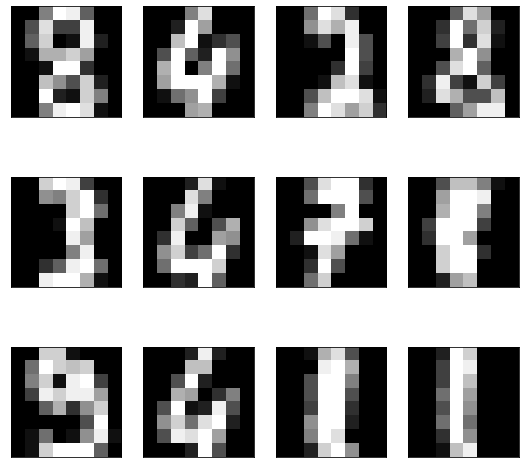

In [24]:
images = X_train[:12]
n_col = 4
n_row = 3

plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for i in range(n_row * n_col):
    
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

In [25]:
y_train[:12]  # prawdziwe etykiety

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Klasyczna sieć neuronowa

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [28]:
model = Sequential()

model.add(Flatten(input_shape=(8, 8, 1)))
model.add(Dense(n_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

model.fit(X_train, y_train, callbacks=[early_stopping], epochs=100, validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9733 - val_loss: 0.1816 - val_accuracy: 0.9633
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9733 - val_loss: 0.1814 - val_accuracy: 0.9633
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1596 - accuracy: 0.9733 - val_loss: 0.1814 - val_accuracy: 0.9633
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9733 - val_loss: 0.1813 - val_accuracy: 0.9633
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1594 - accuracy: 0.9733 - val_loss: 0.1812 - val_accuracy: 0.9633
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9733 - val_loss: 0.1811 - val_accuracy: 0.9633
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9733 - val_loss: 0.1811 - val_accuracy: 0.9633
Epoch 8/100
3

Epoch 59/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.9741 - val_loss: 0.1766 - val_accuracy: 0.9633
Epoch 60/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9733 - val_loss: 0.1765 - val_accuracy: 0.9633
Epoch 61/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.9741 - val_loss: 0.1766 - val_accuracy: 0.9633
Epoch 62/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9741 - val_loss: 0.1766 - val_accuracy: 0.9633
Epoch 63/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1529 - accuracy: 0.9741 - val_loss: 0.1764 - val_accuracy: 0.9633
Epoch 64/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9741 - val_loss: 0.1765 - val_accuracy: 0.9633
Epoch 65/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9741 - val_loss: 0.1765 - val_accuracy: 0.9633
Epoch 

In [34]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9600


[0.17915652692317963, 0.9599999785423279]

## Sieć konwolucyjna

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [37]:
?Conv2D

In [36]:
?MaxPooling2D

In [38]:
model = Sequential()

model.add(Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(8, 8, 1)))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 10)          100       
                                                                 
 flatten_2 (Flatten)         (None, 360)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                3610      
                                                                 
Total params: 3,710
Trainable params: 3,710
Non-trainable params: 0
_________________________________________________________________


In [39]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=16)

Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 2.2794 - categorical_accuracy: 0.3166 - val_loss: 2.2366 - val_categorical_accuracy: 0.6633
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 2.1673 - categorical_accuracy: 0.6349 - val_loss: 2.0752 - val_categorical_accuracy: 0.7833
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 1.9587 - categorical_accuracy: 0.7794 - val_loss: 1.8187 - val_categorical_accuracy: 0.8533
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 1.6660 - categorical_accuracy: 0.8346 - val_loss: 1.4951 - val_categorical_accuracy: 0.8900
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 1.3472 - categorical_accuracy: 0.8797 - val_loss: 1.1973 - val_categorical_accuracy: 0.9033
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 1.0712 - categorical_accuracy: 0.8855 - val_loss: 0.9477 - val_categorical_accuracy: 0.9267
Epoch 7/10

In [40]:
model.evaluate(X_test, y_test, verbose=0)

[0.16939181089401245, 0.95333331823349]

### Zadanie 1 - Zbuduj sieć konwolucyjną
- Ustaw _padding_ "same" - przeanalizuj `model.summary()` względem poprzedniego modelu
- Dodaj _pooling_ po warstwie _konwolucyjnej_
- Dodaj warstwę _gęstą_ po _flatten_

In [41]:
model = Sequential()

model.add(Conv2D(10, 3, activation='relu', input_shape=(8,8,1), padding="same"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

# nowa warstwa gęsta (można przetestować różne f. aktywacji i liczby neuronów)
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 8, 8, 10)          100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 10)         0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 160)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                3220      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
Total params: 3,530
Trainable params: 3,530
Non-trainable params: 0
____________________________________________________

In [42]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=16)

Epoch 1/100
75/75 [==============================] - 1s 5ms/step - loss: 2.3944 - categorical_accuracy: 0.0961 - val_loss: 2.3198 - val_categorical_accuracy: 0.1000
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 2.3048 - categorical_accuracy: 0.1036 - val_loss: 2.2995 - val_categorical_accuracy: 0.0900
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 2.2931 - categorical_accuracy: 0.1328 - val_loss: 2.2890 - val_categorical_accuracy: 0.1200
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 2.2861 - categorical_accuracy: 0.1278 - val_loss: 2.2782 - val_categorical_accuracy: 0.3133
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 2.2713 - categorical_accuracy: 0.2439 - val_loss: 2.2630 - val_categorical_accuracy: 0.2433
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 2.2525 - categorical_accuracy: 0.3417 - val_loss: 2.2364 - val_categorical_accuracy: 0.5667
Epoch 7/10

In [43]:
model.evaluate(X_test, y_test, verbose=0)

[0.1401974856853485, 0.9666666388511658]

### Zadanie 2 - Wykorzystaj 2 warstwy konwolucyjne (po każdej użyj _pooling_)

- Warto sprawdzić _accuracy_ na _X_test_ po każdej modyfikacji. Gdy zacznie rosnąć to przerwać modyfikacje w tym kierunku i szukać innych.
- Warto również dodać i sprawdzić _regularyzację L2_ i warstwy typu _dropout_.

In [44]:
model = Sequential()

# zwiększona liczba kanałów do 16 (można sprawdzić jaka liczba kanałów działa najlepiej)
model.add(Conv2D(16, 3, activation='relu', input_shape=(8, 8, 1), padding="same"))
model.add(MaxPooling2D((2, 2)))

# nowa warstwa konwolucyjna, zazwyczaj w kolejnych warstwach po poolingu liczba kanałów zwiększa się dwukrotnie
model.add(Conv2D(32, 3, activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(20, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 20)               

In [45]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=16)

Epoch 1/100
75/75 [==============================] - 1s 6ms/step - loss: 2.3974 - categorical_accuracy: 0.0944 - val_loss: 2.3078 - val_categorical_accuracy: 0.0967
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 2.3035 - categorical_accuracy: 0.1220 - val_loss: 2.2987 - val_categorical_accuracy: 0.0900
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 2.2931 - categorical_accuracy: 0.1303 - val_loss: 2.2900 - val_categorical_accuracy: 0.1467
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 2.2773 - categorical_accuracy: 0.1504 - val_loss: 2.2601 - val_categorical_accuracy: 0.1733
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 2.2352 - categorical_accuracy: 0.2648 - val_loss: 2.1902 - val_categorical_accuracy: 0.2933
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 2.1197 - categorical_accuracy: 0.3617 - val_loss: 2.0335 - val_categorical_accuracy: 0.4000
Epoch 7/10

In [46]:
model.evaluate(X_test, y_test, verbose=0)

[0.1557731181383133, 0.95333331823349]